In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from ipywidgets import interact, fixed  
from itertools import product
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [16]:
df = pd.read_csv("housing_dataset.csv")
numerical_feature_df= pd.read_csv("Selected_numerical_features.csv")
categorical_feature_df = pd.read_csv("Selected_categorical_features.csv")
categorical_feature_df= categorical_feature_df[["Feature","Frequence"]]

In [17]:
np.max(categorical_feature_df.Frequence)

6

In [18]:
numerical_feature_list = numerical_feature_df[numerical_feature_df["Frequence"]>1].Feature.values
categorical_feature_list = categorical_feature_df[categorical_feature_df["Frequence"]>4].Feature.values
categorical_feature_list

array(['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual',
       'FireplaceQu', 'GarageFinish'], dtype=object)

In [19]:
def feature_selector(num_threshold, categ_threshold,num_feat_df=numerical_feature_df, categ_feat_df=categorical_feature_df):
    numerical_feature_list = numerical_feature_df[numerical_feature_df["Frequence"]>num_threshold].Feature.values
    categorical_feature_list = categorical_feature_df[categorical_feature_df["Frequence"]>categ_threshold].Feature.values
    final_feature = list(numerical_feature_list)+list(categorical_feature_list )
    return final_feature

In [20]:
final_features = feature_selector(4,5)
final_features

['TotalBsmtSF', 'GrLivArea', 'ExterQual', 'KitchenQual']

In [21]:
df=df[final_features+["SalePrice"]]

In [22]:
#@interact(df_arg=fixed(numerical_df),k=(3,0,-0.5))
def remove_outliers_iqr(df_arg,k = 1.5):
    df_iqr = df_arg.copy()
    #columns = [col for col in df_arg.columns]
    for col in df_arg.columns:
        if df_arg[col].dtypes!="object":
            q25, q75 = q25, q75 = df_iqr[col].quantile(.25), df_iqr[col].quantile(.75)
            ecart_iqr = q75- q25
            cut_off = ecart_iqr*k
            lower = q25-cut_off
            upper = q75+cut_off
            df_iqr[col] =np.where(((df_iqr[col]< lower)|(df_iqr[col]> upper)),df_iqr[col].median(),df_iqr[col])
    return df_iqr  

In [23]:
df_work = remove_outliers_iqr(df,3)
df_work.columns

Index(['TotalBsmtSF', 'GrLivArea', 'ExterQual', 'KitchenQual', 'SalePrice'], dtype='object')

In [24]:
df_work.isnull().sum().sum()

0

In [25]:
df_work[final_features].describe()

,TotalBsmtSF,GrLivArea
count,1460.000000,1460.000000
mean,1047.983904,1506.385616
std,403.448325,496.138853
min,0.000000,334.000000
25%,795.750000,1129.500000
50%,991.250000,1464.000000
75%,1288.750000,1774.250000
max,2633.000000,3627.000000


 ## Model Training

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector as selector


def preprocess_data(df_arg,features, train_size=0.8):
    categorical_preprocessor = OrdinalEncoder()
    numerical_preprocessor = MinMaxScaler()
    x_inputs = df_arg.copy().drop(columns=["SalePrice"])[features]
    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)
    numerical_columns = numerical_columns_selector(x_inputs)
    categorical_columns = categorical_columns_selector(x_inputs)
    preprocessor = ColumnTransformer(transformers=[
    ('OrdinalEncoder', categorical_preprocessor,categorical_columns),
    ('min_max_scaler', numerical_preprocessor, numerical_columns)])
    X_processed= preprocessor.fit_transform(x_inputs)
    #y_processed = (df_arg.copy()["SalePrice"]-df_arg.copy()["SalePrice"].min())/((df_arg.copy()["SalePrice"].max()-df_arg.copy()["SalePrice"].min()))
    y_processed = df_arg.copy()["SalePrice"]
    trainX, testX, trainY, testY= train_test_split(X_processed, y_processed, train_size=train_size)
    #trainX.shape, testY.shape
    return trainX, testX, trainY,testY,X_processed,y_processed


In [27]:
def get_metrics(y_true, y_pred,precision=10):
    metrics_dict  = {"MSE": 0,"MAE":0, "RMSE":0,"MAPE":0}
    mse = np.mean(np.power(y_true - y_pred,2))
    metrics_dict["MSE"] = np.round(mse,precision)

    mae = np.mean(np.abs(y_true - y_pred))
    metrics_dict["MAE"] = np.round(mae,precision)
    rmse = np.sqrt(np.mean(np.power(y_true - y_pred,2)))
    metrics_dict["RMSE"] = np.round(rmse,precision)
    mape = 100*np.abs(((y_true - y_pred)/np.abs(y_true))).sum() /len(y_true)
    metrics_dict["MAPE"] = np.round(mape,precision)
    return metrics_dict

In [28]:
trainX, testX, trainY, testY, x,y= preprocess_data(df_work,final_features)
trainX.shape, testY.shape 

TypeError: fit_transform() takes 2 positional arguments but 3 were given

In [ ]:
x.shape

(1460, 10)

In [ ]:
import pickle

In [ ]:
def fit_models(model,df_arg,feature, model_name):
    train_test_metrics = {}
    cross_val_dict={}
    trainX, testX, trainY, testY, X, y= preprocess_data(df_arg,feature)
    model_fit = model.fit(trainX,trainY)
    y_pred =model_fit.predict(testX)
    train_pred = model_fit.predict(trainX)
    train_test_metrics["Train"]=get_metrics(trainY,train_pred)
    train_test_metrics["Test"]=get_metrics(testY,y_pred)
    cv_score =cross_val_score(model,X,y, cv=10)
    cross_val_dict["mean"] =np.mean(cv_score)
    cross_val_dict["std"] = np.std(cv_score)
    pickle.dump(model, open(f"models/{model_name}", 'wb'))
    return y_pred,train_pred,pd.DataFrame.from_dict(train_test_metrics),cross_val_dict

### RandomForest Regeressor

In [ ]:
rf_pred, rf_train_pred, rf_metrics, rf_cv_score =fit_models(RandomForestRegressor(),df_work,final_features, "randomForest.pkl")
rf_metrics

,Train,Test
MSE,2.139545e+08,1.394452e+09
MAE,9.920929e+03,2.534656e+04
RMSE,1.462719e+04,3.734236e+04
MAPE,6.299359e+00,1.494669e+01


In [ ]:
rf_cv_score

{'mean': 0.6975718843346247, 'std': 0.09672960669482907}

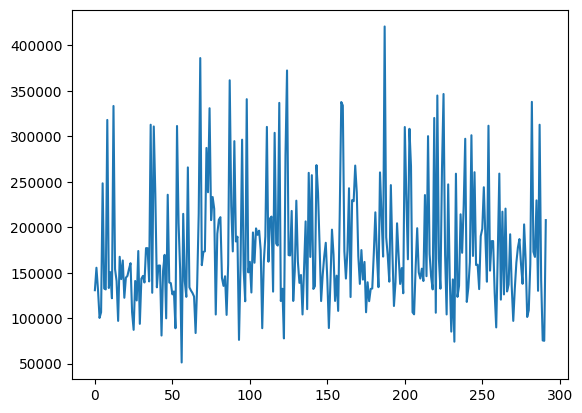

In [ ]:
plt.plot(rf_pred)

### GradientBoostRegressor

In [ ]:
gb_pred, gb_train_pred, gb_metrics, gb_cv_score= fit_models(GradientBoostingRegressor(),df_work,final_features,"gradientboosting.pkl")
gb_metrics

,Train,Test
MSE,6.492010e+08,1.202189e+09
MAE,1.880354e+04,2.512506e+04
RMSE,2.547942e+04,3.467260e+04
MAPE,1.176756e+01,1.593619e+01


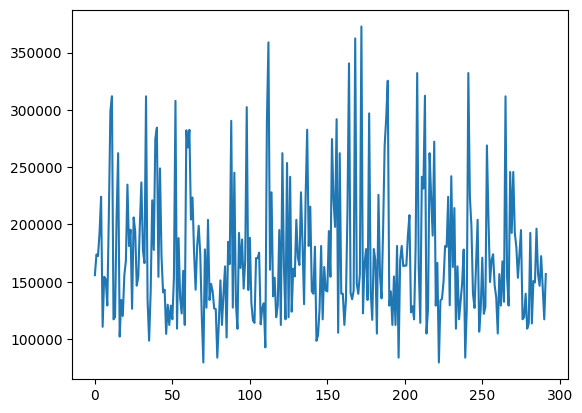

In [ ]:
plt.plot(gb_pred)

In [ ]:
gb_cv_score

{'mean': 0.7258618822008132, 'std': 0.07033553456683624}

### HistGradientBoostRegressor

In [ ]:
hgb_pred, hgb_train_pred, hgb_metrics, hgb_cv_score= fit_models(HistGradientBoostingRegressor(),df_work,final_features,"histgradboosting.pkl")
hgb_metrics

,Train,Test
MSE,6.402496e+08,1.327227e+09
MAE,1.711340e+04,2.404605e+04
RMSE,2.530315e+04,3.643113e+04
MAPE,1.067052e+01,1.474180e+01


In [ ]:
hgb_cv_score

{'mean': 0.7292161818823129, 'std': 0.0676461860853131}

### ExtraTreesRegressor

In [ ]:
et_pred, et_train_pred, et_metrics, et_cv_score= fit_models(ExtraTreesRegressor(),df_work,final_features,"extratreesreg.pkl")
et_metrics

,Train,Test
MSE,2.122668e+07,1.529266e+09
MAE,1.271362e+03,2.609824e+04
RMSE,4.607242e+03,3.910583e+04
MAPE,1.001325e+00,1.692886e+01


In [ ]:
et_cv_score

{'mean': 0.6596574454363606, 'std': 0.10427894709301376}

### SVR

In [ ]:
svr_pred, svr_train_pred, svr_metrics, svr_cv_score = fit_models(svm.SVR(),df_work,final_features,"svr.pkl")

In [ ]:
svr_cv_score

{'mean': -0.04400766758728562, 'std': 0.028147180897565557}

<Axes: >

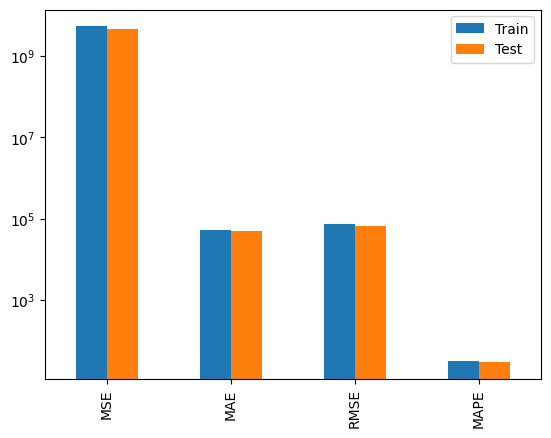

In [ ]:
svr_metrics.plot.bar(logy =True)

### Résumé des modéles 

Text(0.5, 1.0, 'Cross validation score after 10 runs')

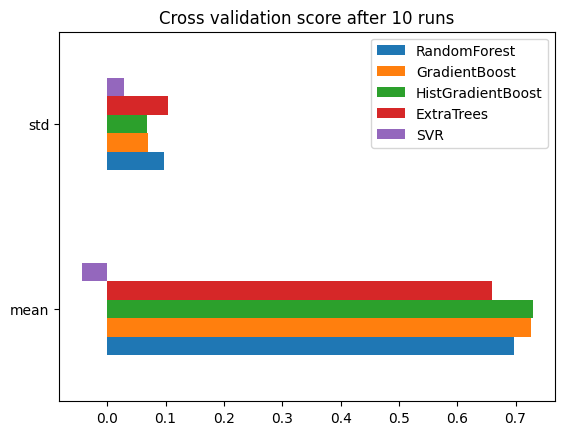

In [ ]:
global_cv_score = pd.DataFrame.from_dict({"RandomForest":rf_cv_score,"GradientBoost":gb_cv_score,"HistGradientBoost":hgb_cv_score,
"ExtraTrees":et_cv_score,"SVR":svr_cv_score})
global_cv_score.plot.barh()
plt.title("Cross validation score after 10 runs")